In [57]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt
from torchsummary import summary
import numpy as np

In [58]:
data = pd.read_csv('./diabetes.csv') 

In [59]:
data

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


<Axes: ylabel='count'>

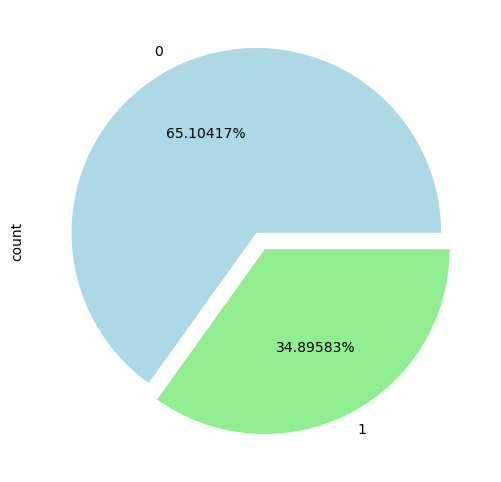

In [60]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 8
fig_size[1] = 6
plt.rcParams["figure.figsize"] = fig_size
data.Outcome.value_counts().plot(
    kind='pie', 
    autopct='%0.05f%%', 
    colors=['lightblue', 'lightgreen'], 
    explode=(0.05, 0.05)
)


In [61]:
# 데이터와 타겟 분리
X = data.drop('Outcome', axis=1).values
y = data['Outcome'].values

In [62]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Standardize the data
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [63]:
data_array = np.hstack((X, y.reshape(-1, 1)))

In [64]:
data_array.shape

(768, 9)

In [65]:
# Split sequences function
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        end_ix = i + n_steps
        if end_ix > len(sequences):
            break
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

# Apply sequence transformation
n_steps = 5
X, y = split_sequences(data_array, n_steps)

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [66]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape, 

((611, 5, 8), (611,), (153, 5, 8), (153,))

In [ ]:
# Convert to PyTorch tensors
# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1) 
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)    


# Create DataLoader
train_dataset = TensorDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = TensorDataset(X_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [68]:
# Define the 1D CNN model
class DiabetestCNN(nn.Module):
    def __init__(self):
        super(DiabetestCNN, self).__init__()
        self.conv1 = nn.Conv1d(8, 16, kernel_size=3, padding=1)  # Change input channels to 6
        self.conv2 = nn.Conv1d(16, 32, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(32 * 5, 64)  # Adjust the linear layer input size accordingly
        self.fc2 = nn.Linear(64, 1)  # 4 classes in the dataset
    
    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
model = DiabetestCNN()
summary(model, input_size=(8, 5))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1                [-1, 16, 5]             400
            Conv1d-2                [-1, 32, 5]           1,568
            Linear-3                   [-1, 64]          10,304
            Linear-4                    [-1, 1]              65
Total params: 12,337
Trainable params: 12,337
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.05
Estimated Total Size (MB): 0.05
----------------------------------------------------------------


In [69]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [70]:
train_losses = []
test_accuracies = []

num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_dataloader:
        optimizer.zero_grad()

        # Forward pass
        inputs = inputs.permute(0, 2, 1)  # (B, seq_len, features) → (B, features, seq_len)
        outputs = model(inputs)  # shape: (B, 1)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_losses.append(running_loss / len(train_dataloader))

    # Evaluation
    model.eval()
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for inputs, labels in test_dataloader:
            inputs = inputs.permute(0, 2, 1)
            outputs = model(inputs)
            probs = torch.sigmoid(outputs)
            predicted = (probs >= 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    accuracy = 100 * correct / total
    test_accuracies.append(accuracy)

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {train_losses[-1]:.4f}, Accuracy: {accuracy:.2f}%")

print("Training complete.")


Epoch 1/20, Loss: 0.6654, Accuracy: 62.75%
Epoch 2/20, Loss: 0.6499, Accuracy: 62.75%
Epoch 3/20, Loss: 0.6098, Accuracy: 62.75%
Epoch 4/20, Loss: 0.5784, Accuracy: 62.75%
Epoch 5/20, Loss: 0.5338, Accuracy: 73.86%
Epoch 6/20, Loss: 0.4877, Accuracy: 78.43%
Epoch 7/20, Loss: 0.4697, Accuracy: 76.47%
Epoch 8/20, Loss: 0.4366, Accuracy: 75.16%
Epoch 9/20, Loss: 0.4155, Accuracy: 77.78%
Epoch 10/20, Loss: 0.4327, Accuracy: 75.82%
Epoch 11/20, Loss: 0.4105, Accuracy: 77.78%
Epoch 12/20, Loss: 0.3954, Accuracy: 76.47%
Epoch 13/20, Loss: 0.3704, Accuracy: 75.16%
Epoch 14/20, Loss: 0.3596, Accuracy: 75.16%
Epoch 15/20, Loss: 0.3580, Accuracy: 73.86%
Epoch 16/20, Loss: 0.3430, Accuracy: 73.86%
Epoch 17/20, Loss: 0.3236, Accuracy: 73.20%
Epoch 18/20, Loss: 0.2903, Accuracy: 74.51%
Epoch 19/20, Loss: 0.3129, Accuracy: 74.51%
Epoch 20/20, Loss: 0.2794, Accuracy: 72.55%
Training complete.


In [71]:
# Convert lists to numpy arrays
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)

# Calculate metrics
conf_matrix = confusion_matrix(all_labels, all_predictions)
f1 = f1_score(all_labels, all_predictions, average='weighted')
precision = precision_score(all_labels, all_predictions, average='weighted')
recall = recall_score(all_labels, all_predictions, average='weighted')

# Calculate specificity for each class
specificity = []
for i in range(conf_matrix.shape[0]):
    tn = conf_matrix.sum() - (conf_matrix[i, :].sum() + conf_matrix[:, i].sum() - conf_matrix[i, i])
    fp = conf_matrix[:, i].sum() - conf_matrix[i, i]
    specificity.append(tn / (tn + fp))

# Print metrics
print(f'Confusion Matrix:\n{conf_matrix}')
print(f'F1 Score: {f1:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'Specificity: {np.mean(specificity):.2f}')

Confusion Matrix:
[[80 16]
 [26 31]]
F1 Score: 0.72
Precision: 0.72
Recall: 0.73
Specificity: 0.69


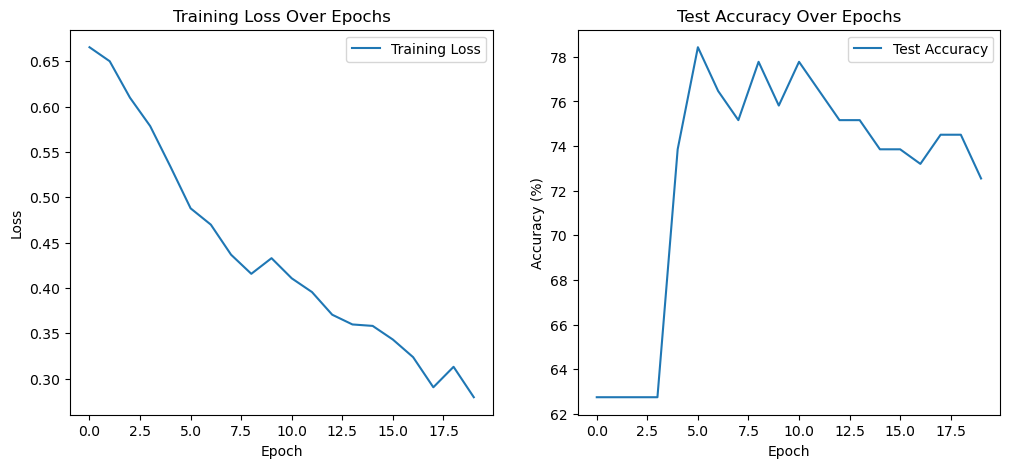

In [72]:
# Plot the loss and accuracy
plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy Over Epochs')
plt.legend()

plt.show()